## ## Audio Quality Dataset - Threshold Optimised

In [513]:
import pandas as pd
import numpy as np
import json
from sklearn.metrics import accuracy_score
from itertools import product
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [514]:
df = pd.read_csv('data/student_audio_quality_review.csv')

In [515]:
df.head()

,Standard,Grade,type,answer_text,questionattemptid,total_rubric_score,Audio Link,Transcription,whisper_words,whisper_segments,whisper_language,Audio Audible,Transcript Acceptable
0,ca,1,speaking,https://summitk12-quiz-audios.s3-accelerate.am...,125420729,0,https://drive.google.com/file/d/1l0sWVznEn_f1o...,The kids are cleaning.,"[{""word"": ""The"", ""start"": 0.62, ""end"": 0.8}, {...","[{""id"": 0, ""seek"": 0, ""start"": 0, ""end"": 3.14,...",Icelandic,Yes,Yes
1,ca,2,speaking,https://summitk12-quiz-audios.s3-accelerate.am...,132724395,0,https://drive.google.com/file/d/1gXqLvabNA9C1P...,. .,"[{""word"": ""."", ""start"": 0, ""end"": 1.08}, {""wor...","[{""id"": 0, ""seek"": 0, ""start"": 0, ""end"": 4.4, ...",English,No,No
2,ca,3,speaking,https://summitk12-quiz-audios.s3-accelerate.am...,154839753,0,https://drive.google.com/file/d/16DS157VCuQikP...,The children are in a forest on a log.,"[{""word"": ""The"", ""start"": 1.86, ""end"": 2.04}, ...","[{""id"": 0, ""seek"": 0, ""start"": 0, ""end"": 7.2, ...",Icelandic,Yes,Yes
3,ca,4,speaking,https://summitk12-quiz-audios.s3-accelerate.am...,95970423,0,https://drive.google.com/file/d/10P9XXQpP93WPz...,Það er mamið. Það er kynnt.,"[{""word"": ""\u00dea\u00f0"", ""start"": 0.02, ""end...","[{""id"": 0, ""seek"": 0, ""start"": 0, ""end"": 1.96,...",Icelandic,No,No
4,ca,5,speaking,https://summitk12-quiz-audios.s3-accelerate.am...,16975931,0,https://drive.google.com/file/d/1FVZwuJm5ks7N2...,It's music class.,"[{""word"": ""It's"", ""start"": 0.76, ""end"": 1.3}, ...","[{""id"": 0, ""seek"": 0, ""start"": 0, ""end"": 2.64,...",Icelandic,Yes,Yes


In [516]:
# Rows and Columns

print(f"Rows: {df.shape[0]}")
print(f"Columns: {df.shape[1]} - {list(df.columns)}")

Rows: 1028
Columns: 13 - ['Standard', 'Grade', 'type', 'answer_text', 'questionattemptid', 'total_rubric_score', 'Audio Link', 'Transcription', 'whisper_words', 'whisper_segments', 'whisper_language', 'Audio Audible', 'Transcript Acceptable']


In [517]:
# Checking if any nulls

df.isnull().sum()

Standard                   0
Grade                      0
type                       0
answer_text                0
questionattemptid          0
total_rubric_score         0
Audio Link                 0
Transcription              0
whisper_words              0
whisper_segments           0
whisper_language           0
Audio Audible            196
Transcript Acceptable    196
dtype: int64

In [518]:
# Drop all rows where Audio Audible is Null

df = df.dropna(subset=['Audio Audible'])

In [519]:
# Convert 'Yes'/'No' values to binary (1/0)

df['Audio Audible'] = df['Audio Audible'].map({'Yes':1, 'No':0})
df['Transcript Acceptable'] = df['Transcript Acceptable'].map({'Yes':1, 'No':0})

In [520]:
# 'Ground Truth' is AND of previous two columns

df['ground_truth'] = df['Audio Audible'] & df['Transcript Acceptable']

In [521]:
df.head()

,Standard,Grade,type,answer_text,questionattemptid,total_rubric_score,Audio Link,Transcription,whisper_words,whisper_segments,whisper_language,Audio Audible,Transcript Acceptable,ground_truth
0,ca,1,speaking,https://summitk12-quiz-audios.s3-accelerate.am...,125420729,0,https://drive.google.com/file/d/1l0sWVznEn_f1o...,The kids are cleaning.,"[{""word"": ""The"", ""start"": 0.62, ""end"": 0.8}, {...","[{""id"": 0, ""seek"": 0, ""start"": 0, ""end"": 3.14,...",Icelandic,1,1,1
1,ca,2,speaking,https://summitk12-quiz-audios.s3-accelerate.am...,132724395,0,https://drive.google.com/file/d/1gXqLvabNA9C1P...,. .,"[{""word"": ""."", ""start"": 0, ""end"": 1.08}, {""wor...","[{""id"": 0, ""seek"": 0, ""start"": 0, ""end"": 4.4, ...",English,0,0,0
2,ca,3,speaking,https://summitk12-quiz-audios.s3-accelerate.am...,154839753,0,https://drive.google.com/file/d/16DS157VCuQikP...,The children are in a forest on a log.,"[{""word"": ""The"", ""start"": 1.86, ""end"": 2.04}, ...","[{""id"": 0, ""seek"": 0, ""start"": 0, ""end"": 7.2, ...",Icelandic,1,1,1
3,ca,4,speaking,https://summitk12-quiz-audios.s3-accelerate.am...,95970423,0,https://drive.google.com/file/d/10P9XXQpP93WPz...,Það er mamið. Það er kynnt.,"[{""word"": ""\u00dea\u00f0"", ""start"": 0.02, ""end...","[{""id"": 0, ""seek"": 0, ""start"": 0, ""end"": 1.96,...",Icelandic,0,0,0
4,ca,5,speaking,https://summitk12-quiz-audios.s3-accelerate.am...,16975931,0,https://drive.google.com/file/d/1FVZwuJm5ks7N2...,It's music class.,"[{""word"": ""It's"", ""start"": 0.76, ""end"": 1.3}, ...","[{""id"": 0, ""seek"": 0, ""start"": 0, ""end"": 2.64,...",Icelandic,1,1,1


In [522]:
# Function to extract mean values
def extract_means(segments):
    avg_logprob = [dct["avg_logprob"] for dct in segments if "avg_logprob" in dct]
    compression_ratio = [dct["compression_ratio"] for dct in segments if "compression_ratio" in dct]
    no_speech_prob = [dct["no_speech_prob"] for dct in segments if "no_speech_prob" in dct]

    return (
        np.mean(avg_logprob),
        np.mean(compression_ratio),
        np.mean(no_speech_prob)
    )

In [523]:
# Temp column with parsed JSON data
df["whisper_segments_parsed"] = df["whisper_segments"].apply(
    lambda x: json.loads(x)
)

In [524]:
# Apply 'extract_means' on the parsed column
df[["mean_avg_logprob", "mean_compression_ratio", "mean_no_speech_prob"]] = (
    df["whisper_segments_parsed"].apply(extract_means).apply(pd.Series)
)

In [525]:
# Drop temp column
df.drop(columns=["whisper_segments_parsed"], inplace=True)

In [526]:
df.head()

,Standard,Grade,type,answer_text,questionattemptid,total_rubric_score,Audio Link,Transcription,whisper_words,whisper_segments,whisper_language,Audio Audible,Transcript Acceptable,ground_truth,mean_avg_logprob,mean_compression_ratio,mean_no_speech_prob
0,ca,1,speaking,https://summitk12-quiz-audios.s3-accelerate.am...,125420729,0,https://drive.google.com/file/d/1l0sWVznEn_f1o...,The kids are cleaning.,"[{""word"": ""The"", ""start"": 0.62, ""end"": 0.8}, {...","[{""id"": 0, ""seek"": 0, ""start"": 0, ""end"": 3.14,...",Icelandic,1,1,1,-0.046498,0.733333,1.837492e-10
1,ca,2,speaking,https://summitk12-quiz-audios.s3-accelerate.am...,132724395,0,https://drive.google.com/file/d/1gXqLvabNA9C1P...,. .,"[{""word"": ""."", ""start"": 0, ""end"": 1.08}, {""wor...","[{""id"": 0, ""seek"": 0, ""start"": 0, ""end"": 4.4, ...",English,0,0,0,-2.041714,0.272727,5.108253e-10
2,ca,3,speaking,https://summitk12-quiz-audios.s3-accelerate.am...,154839753,0,https://drive.google.com/file/d/16DS157VCuQikP...,The children are in a forest on a log.,"[{""word"": ""The"", ""start"": 1.86, ""end"": 2.04}, ...","[{""id"": 0, ""seek"": 0, ""start"": 0, ""end"": 7.2, ...",Icelandic,1,1,1,-0.189879,0.904762,2.074286e-10
3,ca,4,speaking,https://summitk12-quiz-audios.s3-accelerate.am...,95970423,0,https://drive.google.com/file/d/10P9XXQpP93WPz...,Það er mamið. Það er kynnt.,"[{""word"": ""\u00dea\u00f0"", ""start"": 0.02, ""end...","[{""id"": 0, ""seek"": 0, ""start"": 0, ""end"": 1.96,...",Icelandic,0,0,0,-0.640734,0.941176,2.977847e-10
4,ca,5,speaking,https://summitk12-quiz-audios.s3-accelerate.am...,16975931,0,https://drive.google.com/file/d/1FVZwuJm5ks7N2...,It's music class.,"[{""word"": ""It's"", ""start"": 0.76, ""end"": 1.3}, ...","[{""id"": 0, ""seek"": 0, ""start"": 0, ""end"": 2.64,...",Icelandic,1,1,1,-0.351254,0.680000,3.434895e-10


In [527]:
# Calculate Min and Max

min_avg_logprob = df['mean_avg_logprob'].min()
min_compress_ratio = df['mean_compression_ratio'].min()
min_no_speech_prob = df['mean_no_speech_prob'].min()

max_avg_logprob = df['mean_avg_logprob'].max()
max_compress_ratio = df['mean_compression_ratio'].max()
max_no_speech_prob = df['mean_no_speech_prob'].max()

In [528]:
# Create Threshold Ranges

log_prob_thresh = np.linspace(min_avg_logprob, max_avg_logprob, 25)

compress_ratio_thresh = np.linspace(min_compress_ratio, max_compress_ratio, 25)

log_min = np.log10(min_no_speech_prob)
log_max = np.log10(max_no_speech_prob)

no_speech_prob_thresh = np.logspace(log_min, log_max, 25)

In [529]:
# Find the best threshold combination for maximum accuracy

best_accuracy = 0
best_thresholds = None

for log_prob, compress_ratio, nospeech_prob in product(log_prob_thresh, compress_ratio_thresh, no_speech_prob_thresh):

    df["temp_output"] = (
        (df["mean_avg_logprob"] > log_prob) &
        (df["mean_compression_ratio"] < compress_ratio) &
        (df["mean_no_speech_prob"] < nospeech_prob)
    ).astype(int)

    acc = accuracy_score(df["ground_truth"], df["temp_output"])

    if acc > best_accuracy:
        best_accuracy = acc
        best_thresholds = (log_prob, compress_ratio, nospeech_prob)
print(f"Accuracy: {best_accuracy:.4f}")

Accuracy: 0.7885


In [530]:
df.drop(columns=["temp_output"], inplace=True)

In [531]:
# Apply best thresholds to get final output
def final_classify(row):
    if (
        row["mean_avg_logprob"] > best_thresholds[0] and
        row["mean_compression_ratio"] < best_thresholds[1] and
        row["mean_no_speech_prob"] < best_thresholds[2]
    ):
        return 1
    return 0

df["predicted_output"] = df.apply(final_classify, axis=1)


In [532]:
df["predicted_output"].value_counts()

predicted_output
0    424
1    408
Name: count, dtype: int64

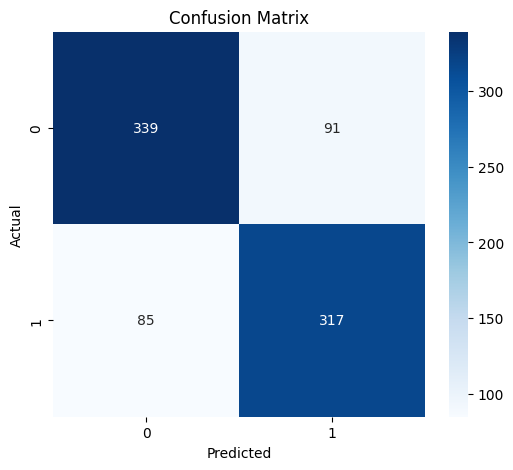

In [533]:
# Display Confusion Matrix
y_true = df['ground_truth']
y_pred = df['predicted_output']

cm = confusion_matrix(y_true, y_pred)
# print(cm)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [534]:
# Display Classification Report
report = classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.80      0.79      0.79       430
           1       0.78      0.79      0.78       402

    accuracy                           0.79       832
   macro avg       0.79      0.79      0.79       832
weighted avg       0.79      0.79      0.79       832

